In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("MXvideos.csv", encoding='ISO-8859-1')


In [3]:
df.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,SbOwzAl9ZfQ,17.14.11,CapÃ­tulo 12 | MasterChef 2017,MasterChef 2017,24,2017-11-13T06:06:22.000Z,"MasterChef Junior 2017|""TV Azteca""|""recetas""|""...",310130,4182,361,1836,https://i.ytimg.com/vi/SbOwzAl9ZfQ/default.jpg,False,False,False,Disfruta la presencia del Chef Torreblanca en ...
1,klOV6Xh-DnI,17.14.11,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Micky Contreras Martinez,22,2017-11-13T05:11:58.000Z,La Voz Mexico 7,104972,271,174,369,https://i.ytimg.com/vi/klOV6Xh-DnI/default.jpg,False,False,False,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...
2,6L2ZF7Qzsbk,17.14.11,LOUIS CKAGÃ - EL PULSO DE LA REPÃBLICA,El Pulso De La RepÃºblica,25,2017-11-13T17:00:02.000Z,"Chumel Torres|""El Pulso de la Republica""|""noti...",136064,10105,266,607,https://i.ytimg.com/vi/6L2ZF7Qzsbk/default.jpg,False,False,False,La canciÃ³n del principio se llama âEste esp...
3,hcY52MFWMDM,17.14.11,Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017,Casanare,25,2017-11-13T03:47:10.000Z,"temblor|""costa rica""|""sismo en costa rica""",96153,378,171,208,https://i.ytimg.com/vi/hcY52MFWMDM/default.jpg,False,False,False,El video es de un Walmart en el pais centroame...
4,_OXDcGPVAa4,17.14.11,DOG HACKS | MUSAS LESSLIE LOS POLINESIOS,Musas,26,2017-11-13T19:17:48.000Z,"MUSAS|""lesslie""|""karen""|""hacks""|""perros""|""dogs...",499965,57781,681,7428,https://i.ytimg.com/vi/_OXDcGPVAa4/default.jpg,False,False,False,MI HERMANO NARRA MI RUTINA DE MAQUILLAJE\nhttp...


In [4]:
df.shape

(40451, 16)

In [5]:
missing_values = df.isnull().sum()
missing_values

video_id                     0
trending_date                0
title                        0
channel_title                0
category_id                  0
publish_time                 0
tags                         0
views                        0
likes                        0
dislikes                     0
comment_count                0
thumbnail_link               0
comments_disabled            0
ratings_disabled             0
video_error_or_removed       0
description               4224
dtype: int64

In [6]:
df.dtypes

video_id                  object
trending_date             object
title                     object
channel_title             object
category_id                int64
publish_time              object
tags                      object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
thumbnail_link            object
comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
description               object
dtype: object

In [7]:
# Remove rows with disabled like counts to avoid negativelt impacting the model
df = df[df["ratings_disabled"] == False]
# Remove rows with video errors or removed videos
df = df[df["video_error_or_removed"] == False]
# Remove rows with disabled comments
df = df[df["comments_disabled"] == False]

In [8]:
df.shape

(39489, 16)

In [9]:
# Remove unnecessary columns
drop_columns = ["video_id", "title", "channel_title", "tags", "thumbnail_link", "ratings_disabled", "video_error_or_removed", "comments_disabled", "description"]
df = df.drop(columns=drop_columns)
df.shape

(39489, 7)

In [10]:
# publish_time is already in ISO format, can be translated directly
df["publish_time"] = pd.to_datetime(df["publish_time"], utc=True).dt.tz_localize(None)

# Convert 'trending_date' to datetime format
# The format is 'YY.DD.MM', so we need to specify the correct format
df["trending_date"] = pd.to_datetime(df["trending_date"], format="%y.%d.%m", errors='coerce').dt.tz_localize(None)

# Get the difference between two dates in days
df["days_to_trend"] = (df["trending_date"] - df["publish_time"]).dt.days

# Remove the 'trending_date' and 'publish_time' columns as it's no longer needed
df = df.drop(columns=["trending_date", "publish_time"], axis=1)

df.shape

(39489, 6)

In [11]:
df.head()

,category_id,views,likes,dislikes,comment_count,days_to_trend
0,24,310130,4182,361,1836,0
1,22,104972,271,174,369,0
2,25,136064,10105,266,607,0
3,25,96153,378,171,208,0
4,26,499965,57781,681,7428,0


In [12]:
from scipy.stats import zscore

# Only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Z-score calculation
z_scores = zscore(numeric_df)
outlier_rows = (abs(z_scores) > 3).any(axis=1)
outliers = df[outlier_rows]

print(f"\nTotal number of outlier rows: {outliers.shape[0]}")
print(outliers.head())



Total number of outlier rows: 2072
    category_id    views  likes  dislikes  comment_count  days_to_trend
24            2    28186     15         9              5              1
25            1     7127     37         3             13              0
35            1   142325  12027       165            362              0
53            1  1096327  33966       798            882              1
59            1    32201   1634        91            469              0


In [13]:
numeric_df.shape

(39489, 6)

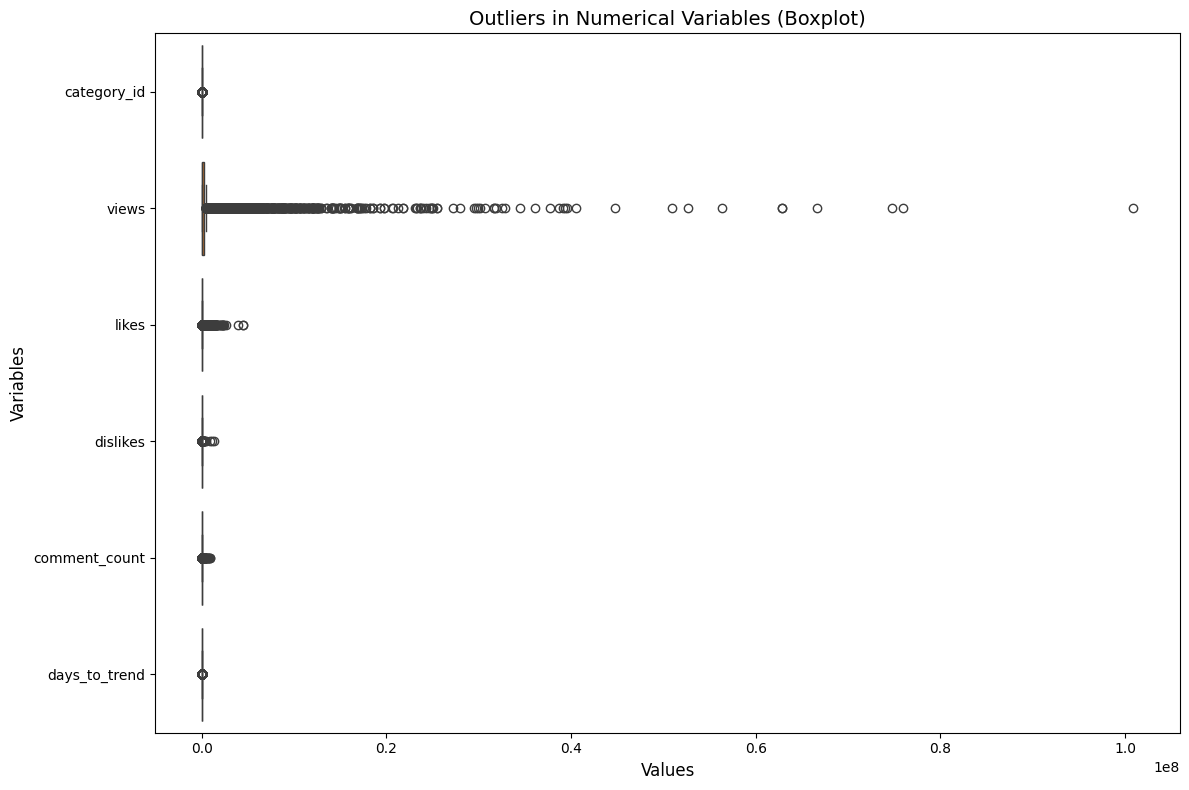

In [14]:
# Plotting the distribution of numeric columns
plt.figure(figsize=(12,8))
sns.boxplot(data=numeric_df, orient="h")
plt.title("Outliers in Numerical Variables (Boxplot)", fontsize=14)
plt.xlabel("Values", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
missing_values = df.isnull().sum()
missing_values

category_id      0
views            0
likes            0
dislikes         0
comment_count    0
days_to_trend    0
dtype: int64

In [16]:
# Log transformation (we add 1 because log(0) is undefined)
df['log_views'] = np.log1p(df['views'])
df['log_likes'] = np.log1p(df['likes'])
df['log_dislikes'] = np.log1p(df['dislikes'])
df['log_comment_count'] = np.log1p(df['comment_count'])

df


,category_id,views,likes,dislikes,comment_count,days_to_trend,log_views,log_likes,log_dislikes,log_comment_count
0,24,310130,4182,361,1836,0,12.644750,8.338784,5.891644,7.515889
1,22,104972,271,174,369,0,11.561458,5.605802,5.164786,5.913503
2,25,136064,10105,266,607,0,11.820888,9.220885,5.587249,6.410175
3,25,96153,378,171,208,0,11.473706,5.937536,5.147494,5.342334
4,26,499965,57781,681,7428,0,13.122295,10.964433,6.525030,8.913147
...,...,...,...,...,...,...,...,...,...,...
40446,17,653114,65639,547,3826,0,13.389509,11.091941,6.306275,8.249836
40447,25,121674,3558,58,491,0,11.709109,8.177235,4.077537,6.198479
40448,24,14067,538,6,90,0,9.551658,6.289716,1.945910,4.510860
40449,22,22898,94,11,3,0,10.038849,4.553877,2.484907,1.386294


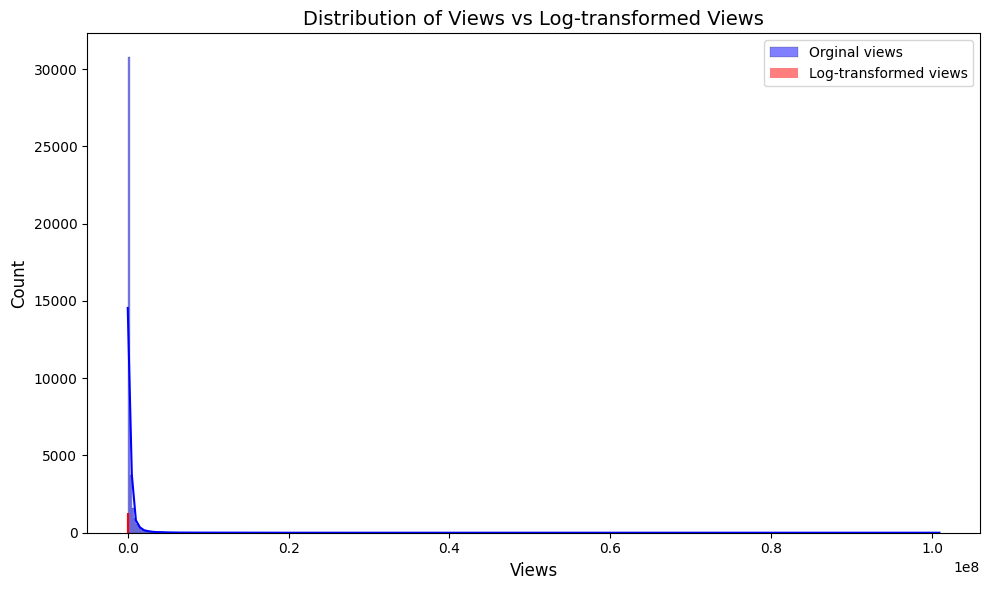

In [17]:
plt.figure(figsize=(10,6))

# Plotting the distribution of orginal views
sns.histplot(df["views"], color="blue", label="Orginal views", kde=True, stat="count")

# Plotting the distribution of log-transformed views
sns.histplot(df["log_views"], color="red", label="Log-transformed views", kde=True, stat="count")

plt.title("Distribution of Views vs Log-transformed Views", fontsize=14)
plt.xlabel("Views", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

## Lineer Regression

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,precision_score, recall_score, confusion_matrix


X = df[['log_likes', 'log_dislikes', 'log_comment_count', 'category_id', 'days_to_trend']]
y = df['log_views']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred) 
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)

print("Linear Regression Model Performance:")
print(f"Mean Square Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2) Value: {r2}")

Linear Regression Model Performance:
Mean Square Error (MSE): 0.5221857285599092
Mean Absolute Error (MAE): 0.5750866851768366
R-squared (R2) Value: 0.8290163550947659


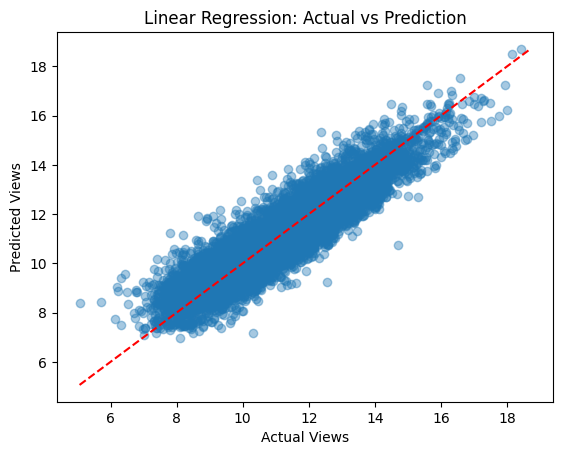

In [20]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.4)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')  # Diagonal line for reference

plt.xlabel("Actual Views")
plt.ylabel("Predicted Views")
plt.title("Linear Regression: Actual vs Prediction")
plt.show()


In [21]:
df_comparison = pd.DataFrame({
    "Actual Views": y_test,
    "Predicted Views": y_pred
})

df_comparison['Ratio'] = df_comparison["Actual Views"] / df_comparison["Predicted Views"]

In [22]:
df_comparison

,Actual Views,Predicted Views,Ratio
9093,12.752595,12.448202,1.024453
18080,9.313979,10.111846,0.921096
12001,11.831946,12.031725,0.983396
13277,10.552317,9.497813,1.111026
29628,10.721217,10.145642,1.056731
...,...,...,...
3559,8.003029,8.035146,0.996003
7868,10.116500,9.526516,1.061931
9329,9.037415,9.709379,0.930792
6821,12.508064,12.152252,1.029280


## Decision Tree Regressor

In [29]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV

model_dt = DecisionTreeRegressor(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {'max_depth': [None, 2, 4, 6, 8, 10],}

grid_search = GridSearchCV(model_dt, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best depth
print(f"Best max_depth: {grid_search.best_params_['max_depth']}")

Best max_depth: 10


In [30]:
# Trin the model with the best parameters
dt_model = DecisionTreeRegressor(max_depth=grid_search.best_params_['max_depth'], random_state=42)
# Fit the model to the training data    
dt_model.fit(X_train, y_train)

# Predicting with the decision tree model
y_pred_dt = dt_model.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)  # Mean square error
r2_dt = r2_score(y_test, y_pred_dt)  # R-kare value
mae_dt = mean_absolute_error(y_test,y_pred_dt) # Mean Absolute Error

# Print the results
print("Decision Tree Model Performance:")
print(f"Mean Square Error (MSE): {mse_dt}")
print(f"R-squared (R2) Value: {r2_dt}")
print(f"Mean Absolute Error (MAE): {mae}")

Decision Tree Model Performance:
Mean Square Error (MSE): 0.45719948462185195
R-squared (R2) Value: 0.850295345020196
Mean Absolute Error (MAE): 0.5750866851768366


Text(0.5, 1.0, 'Decision Tree')

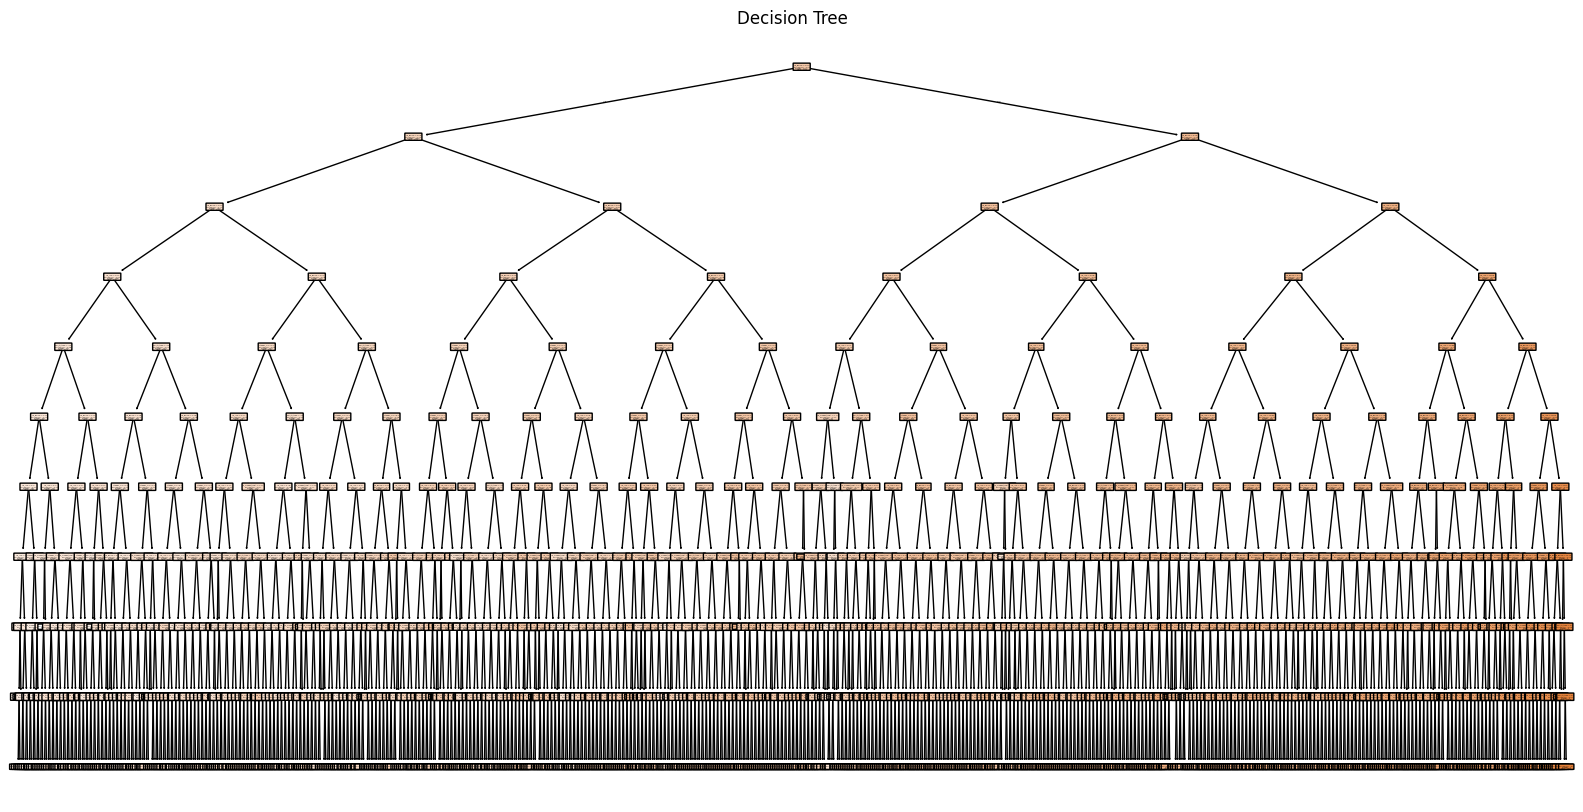

In [32]:
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X.columns, filled=True, rounded=True)
plt.title("Decision Tree")

## Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)  # Mean square error
r2_rf = r2_score(y_test, y_pred_rf)  # R-kare
mae_rf = mean_absolute_error(y_test, y_pred_rf)  # Mean Absolute Error

print("Random Forest Model Performance:")
print(f"Mean Square Error (MSE): {mse_rf}")
print(f"R-squared (R2) Value: {r2_rf}") 
print(f"Mean Absolute Error (MAE): {mae_rf}")



Random Forest Model Performance:
Mean Square Error (MSE): 0.4005066170286561
R-squared (R2) Value: 0.8688587652958659
Mean Absolute Error (MAE): 0.47347497464193755


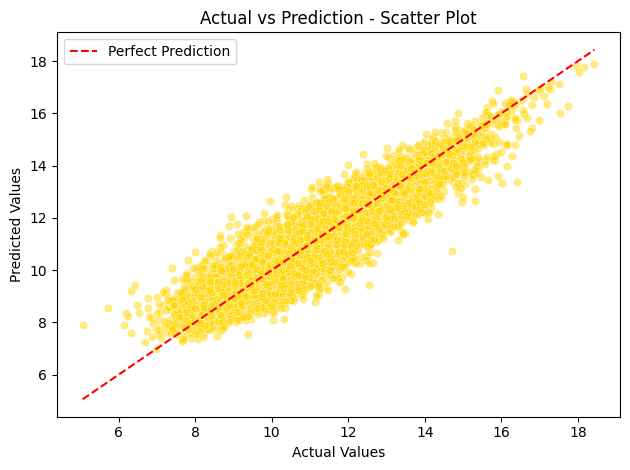

In [26]:
sns.scatterplot(x=y_test, y=y_pred_rf, color='gold', alpha=0.5)

# Mükemmel tahmin çizgisi (y = x)
min_val = min(y_test.min(), y_pred_rf.min())
max_val = max(y_test.max(), y_pred_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Prediction - Scatter Plot")
plt.legend()
plt.tight_layout()
plt.show()

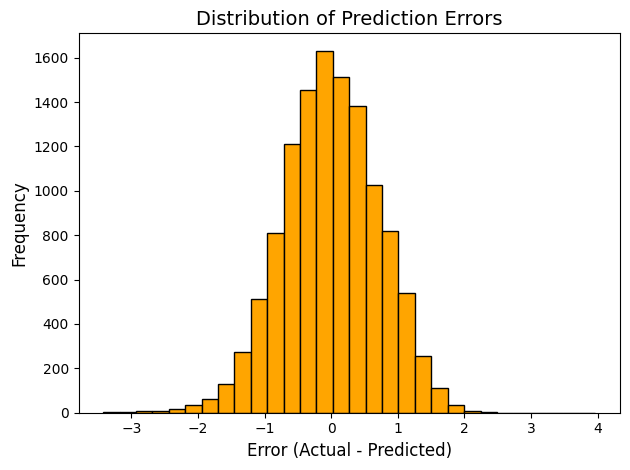

In [27]:
# Plotting the distribution of prediction errors
errors = y_test - y_pred

plt.hist(errors, bins=30, color='orange', edgecolor='black')
plt.title("Distribution of Prediction Errors", fontsize=14)
plt.xlabel("Error (Actual - Predicted)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()


# Comparison of Regression Models

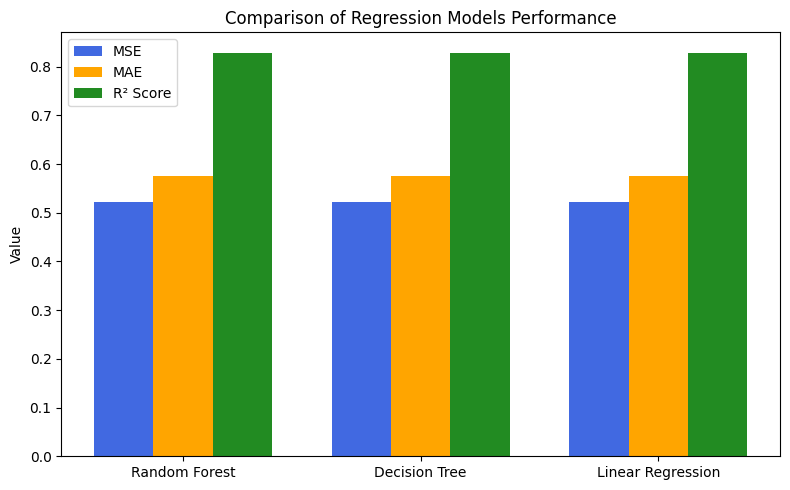

In [28]:
models = ['Random Forest', 'Decision Tree', 'Linear Regression']

# Performance metrics 
mse_list = [mse_rf, mse_dt, mse]
mae_list = [mae_rf, mae_dt, mae]
r2_list = [r2_rf, r2_dt, r2]

# Bar positions
x = np.arange(len(models))
width = 0.25

# Creating the bar plot
plt.figure(figsize=(8, 5))
plt.bar(x - width, mse, width, label='MSE', color='royalblue')
plt.bar(x, mae, width, label='MAE', color='orange')
plt.bar(x + width, r2, width, label='R² Score', color='forestgreen')

# Labeling the bars
plt.xticks(x, models)
plt.ylabel("Value")
plt.title("Comparison of Regression Models Performance")
plt.legend()
plt.tight_layout()
plt.show()